In [1]:
!git clone https://github.com/Kotyga/Emotion_Recognition.git

Cloning into 'Emotion_Recognition'...
remote: Enumerating objects: 3439, done.
remote: Counting objects: 100% (3439/3439), done.
remote: Compressing objects: 100% (3438/3438), done.
remote: Total 3439 (delta 0), reused 3439 (delta 0), pack-reused 0
Receiving objects: 100% (3439/3439), 319.97 MiB | 17.79 MiB/s, done.
Checking out files: 100% (3434/3434), done.


In [2]:
import os, shutil
os.path.isdir('Emotion_Recognition/data/train')

True

In [3]:
import os
import re
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import itertools

In [4]:
dataset_path = 'Emotion_Recognition/data/'
train_folder = 'train'
test_folder = 'test'

emotions = { 
    0: u'гнев', 
    1: u'отвращение', 
    2: u'страх', 
    3: u'счастье', 
    4: u'нейтральный окрас', 
    5: u'печаль', 
    6: u'удивление', 
    7: u'скука'
}

In [5]:
train_files_list = os.listdir(dataset_path + train_folder)
emotion_df = []

for audio_file in train_files_list:
  emotion_df.append((
      dataset_path + train_folder + os.sep + audio_file, 
      emotions.get(int(audio_file.split("_")[1][:1]))
  ))

audio_files_dataframe = pd.DataFrame.from_dict(emotion_df)
audio_files_dataframe.rename(columns={0: "Path", 1: "Emotion"}, inplace=True)
audio_files_dataframe.head()

,Path,Emotion
0,Emotion_Recognition/data/train/1315_2.wav,страх
1,Emotion_Recognition/data/train/2897_5.wav,печаль
2,Emotion_Recognition/data/train/1847_3.wav,счастье
3,Emotion_Recognition/data/train/2090_4.wav,нейтральный окрас
4,Emotion_Recognition/data/train/2067_6.wav,удивление


In [6]:
audio_files_dataframe.shape

(3052, 2)

<Figure size 864x720 with 0 Axes>

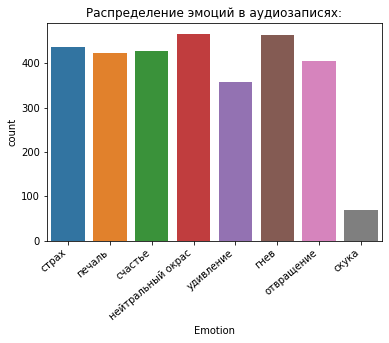

<Figure size 864x720 with 0 Axes>

In [7]:
%matplotlib inline

plt.title(u'Распределение эмоций в аудиозаписях:')
ax = sns.countplot(x="Emotion", data=audio_files_dataframe)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=10, ha="right")
plt.figure(figsize=(12, 10))

In [8]:
def create_waveplot(data, sr, e):
  plt.figure(figsize=(10, 3))
  plt.title(f'Создать график амплитуды для эмоции "{e}"', size=15)
  librosa.display.waveplot(data, sr=sr)
  plt.show()

def create_spectrogram(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12, 3))
  plt.title('Спектрограмма для эмоции "{}"'.format(e), size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

def display_audio_diagrams(file_path, emotion: str):
  path = np.array(audio_files_dataframe.Path[audio_files_dataframe.Emotion==emotion])[1]
  data, sampling_rate = librosa.load(path)
  create_waveplot(data, sampling_rate, emotion)
  create_spectrogram(data, sampling_rate, emotion)

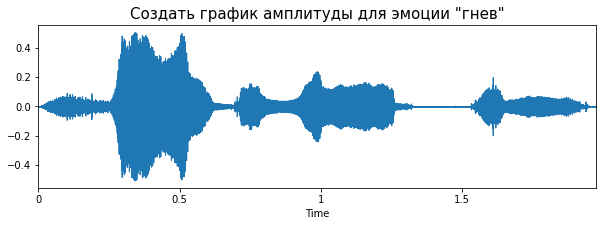

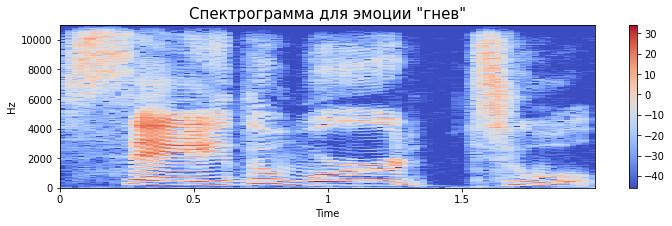

In [9]:
emotion = u'гнев'
path = np.array(audio_files_dataframe.Path[audio_files_dataframe.Emotion==emotion])[1]
display_audio_diagrams(path, emotion)
Audio(path)

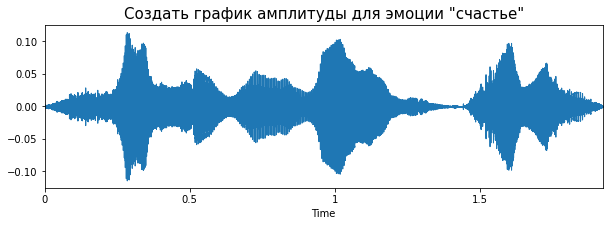

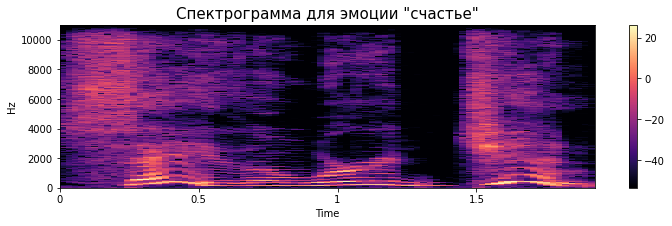

In [10]:
emotion = u'счастье'
path = np.array(audio_files_dataframe.Path[audio_files_dataframe.Emotion==emotion])[1]
display_audio_diagrams(path, emotion)
Audio(path)

In [11]:
n_fft = 2048
hop_length = 512

In [12]:
def chunks(data, frame_length, hop_length):
  for i in range(0, len(data), hop_length):
      yield data[i:i+frame_length]

def zcr(data, frame_length=2048, hop_length=512):
  zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
  return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
  en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
  return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
  rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
  return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
  energies = energy(data, frame_length, hop_length)
  energies /= np.sum(energies)

  entropy = 0.0
  entropy -= energies * np.log2(energies)
  return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
  spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
  return np.squeeze(spectral_centroid)

def spc_flux(data):
  isSpectrum = data.ndim == 1
  if isSpectrum:
      data = np.expand_dims(data, axis=1)

  X = np.c_[data[:, 0], data]
  af_Delta_X = np.diff(X, 1, axis=1)
  vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

  return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
  spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
  return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
  stft = np.abs(librosa.stft(data))
  chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
  return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
  mel = librosa.feature.melspectrogram(y=data, sr=sr)
  return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
  mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
  return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [13]:
path = np.array(audio_files_dataframe["Path"])[0]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sample_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sample_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sample_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sample_rate).shape)
print("MFCC: ", mfcc(data, sample_rate).shape)

ZCR:  (53,)
Energy:  (53,)
Entropy of Energy : (53,)
RMS : (53,)
Spectral Centroid : (53,)
Spectral Flux:  ()
Spectral Rollof:  (53,)
Chroma STFT:  (636,)
MelSpectrogram:  (6784,)
MFCC:  (1060,)


In [14]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
  result = np.array([])
  result = np.hstack((
      result,
      zcr(data, frame_length, hop_length),
      rmse(data, frame_length, hop_length),
      mfcc(data, sr, frame_length, hop_length)
  ))
  return result

def get_features(path, duration=2.5, offset=0.6):
  data, sample_rate = librosa.load(path, duration=duration, offset=offset)

  features = extract_features(data, sample_rate)
  result = np.array(features)

  return result

In [15]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(audio_files_dataframe.Path, audio_files_dataframe.Emotion, range(audio_files_dataframe.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    X.append(features)
    Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

In [16]:
features_path = "features.csv"

extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.032715,0.042480,0.048828,0.040527,0.040039,0.044922,0.051758,0.058105,0.076660,0.090332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,страх
1,0.009766,0.014160,0.018555,0.018555,0.018555,0.018555,0.021484,0.023438,0.023438,0.025879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,печаль
2,0.019531,0.031738,0.044922,0.049805,0.060547,0.065918,0.068359,0.068848,0.068359,0.080566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,счастье
3,0.009766,0.016602,0.025879,0.029785,0.034668,0.037109,0.037109,0.034668,0.030273,0.025391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нейтральный окрас
4,0.017578,0.023926,0.029785,0.025879,0.023926,0.023438,0.031738,0.061523,0.065430,0.065430,...,1.783679,2.078048,2.554281,1.914986,0.463515,-0.65562,-0.694649,0.250284,1.745414,удивление


In [17]:
extracted_df = pd.read_csv('features.csv')
print(extracted_df.shape)

(3052, 2377)


In [18]:
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(3052, 2377)

In [19]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['гнев' 'нейтральный окрас' 'отвращение' 'печаль' 'скука' 'страх'
 'счастье' 'удивление']


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2441, 2376), (611, 2376), (2441, 8), (611, 8))

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((2196, 2376), (611, 2376), (245, 2376), (2196, 8), (611, 8), (245, 8))

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((2196, 2376), (611, 2376), (245, 2376), (2196, 8), (611, 8), (245, 8))

In [23]:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(2196, 2376, 1)

In [24]:
earlystopping = EarlyStopping(
  monitor ="val_acc",
  mode = 'auto', patience = 5,
  restore_best_weights = True
)

learning_rate_reduction = ReduceLROnPlateau(
  monitor='val_acc',
  patience=3,
  verbose=1,
  factor=0.5,
  min_lr=0.00001
)

In [25]:
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
model = models.Sequential()
model.add(layers.Conv1D(
  512, kernel_size=5, strides=1,
  padding="same", activation="relu",
  input_shape=(X_train.shape[1], 1))
)
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(
  512, kernel_size=5, strides=1,
  padding="same", activation="relu")
)
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(
  256, kernel_size=5, strides=1,
  padding="same", activation="relu")
)
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2376, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 1188, 512)        2048      
 hNormalization)                                                 
                                                        

In [27]:
EPOCHS = 10
batch_size = 64

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(2196, 2376, 1) (2196, 8) (245, 2376, 1) (245, 8)


In [28]:
history = model.fit(
  X_train, y_train, validation_data=(X_val, y_val), 
  epochs=EPOCHS, batch_size=batch_size, 
  callbacks=[earlystopping, learning_rate_reduction]
)

Epoch 1/10
35/35 [==============================] - 647s 18s/step - loss: 1.8234 - acc: 0.5282 - f1_m: 0.5227 - val_loss: 3.0506 - val_acc: 0.1429 - val_f1_m: 0.1167 - lr: 0.0010
Epoch 2/10
35/35 [==============================] - 642s 18s/step - loss: 0.9387 - acc: 0.7113 - f1_m: 0.7073 - val_loss: 3.5954 - val_acc: 0.1469 - val_f1_m: 0.1310 - lr: 0.0010
Epoch 3/10
35/35 [==============================] - 641s 18s/step - loss: 0.7022 - acc: 0.7750 - f1_m: 0.7813 - val_loss: 4.6187 - val_acc: 0.1347 - val_f1_m: 0.1312 - lr: 0.0010
Epoch 4/10
35/35 [==============================] - 641s 18s/step - loss: 0.5319 - acc: 0.8342 - f1_m: 0.8334 - val_loss: 3.8800 - val_acc: 0.1551 - val_f1_m: 0.1470 - lr: 0.0010
Epoch 5/10
35/35 [==============================] - 644s 18s/step - loss: 0.4185 - acc: 0.8675 - f1_m: 0.8650 - val_loss: 5.2126 - val_acc: 0.1429 - val_f1_m: 0.1424 - lr: 0.0010
Epoch 6/10
35/35 [==============================] - 646s 18s/step - loss: 0.3092 - acc: 0.8957 - f1_m: 0.